##IMPORT DATASET

In [ ]:
!pip install -q kaggle

In [ ]:
import json
import os

os.makedirs('/root/.kaggle', exist_ok=True)
credentials = {"username":"","key":""}
with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(credentials, f)
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d michiard/dcase-aml
# Unzip a file named "aerial-cactus.zip" into the `/content/` directory
!unzip /content/dcase-aml.zip -d /content/dcase-aml/

Dataset URL: https://www.kaggle.com/datasets/michiard/dcase-aml
License(s): CC-BY-SA-4.0
User cancelled operation
Archive:  /content/dcase-aml.zip
replace /content/dcase-aml/dev_data/dev_data/slider/test/anomaly_id_00_00000000.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## INITIAL EXPLORATION WITH SOME EXAMPLES, can skip and go directly to **INFERENCE ON PRETRAINED** section

In [ ]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import librosa

# Load and resample to 16kHz mono
waveform_standard, sr = librosa.load("/content/dcase-aml/dev_data/dev_data/slider/train/normal_id_00_00000000.wav", sr=16000, mono=True)
waveform_anomlaous, sr = librosa.load("/content/dcase-aml/dev_data/dev_data/slider/test/anomaly_id_00_00000000.wav", sr=16000, mono=True)
# Ensure it's float32
waveform_standard = waveform_standard.astype('float32')
waveform_anomlaous = waveform_anomlaous.astype('float32')


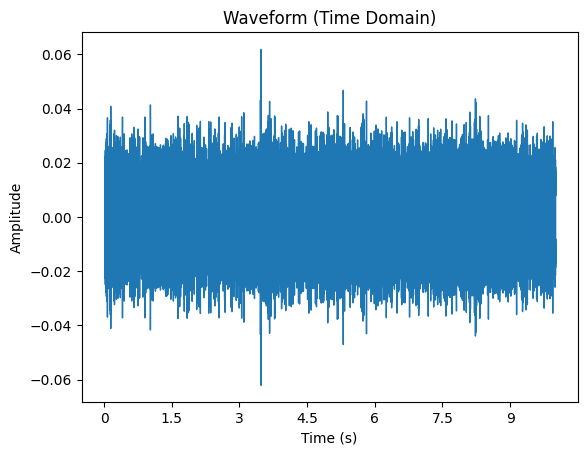

In [ ]:
import matplotlib.pyplot as plt
librosa.display.waveshow(waveform_standard, sr=sr)
plt.title("Waveform (Time Domain)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

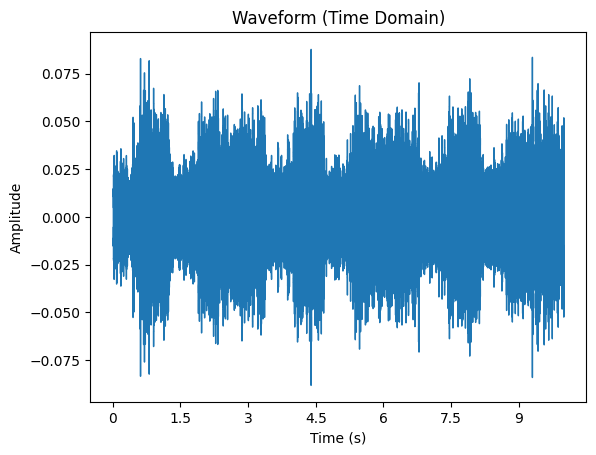

In [ ]:
import matplotlib.pyplot as plt
librosa.display.waveshow(waveform_anomlaous, sr=sr)
plt.title("Waveform (Time Domain)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

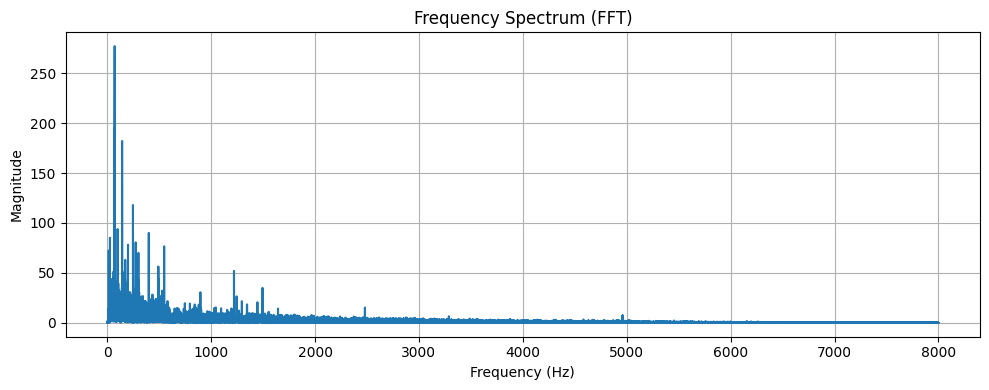

In [ ]:
fft = np.fft.fft(waveform_standard)
magnitude = np.abs(fft)
freq = np.fft.fftfreq(len(magnitude), 1/sr)

# Only keep the positive frequencies
half_len = len(magnitude) // 2
magnitude = magnitude[:half_len]
freq = freq[:half_len]

# Plot
plt.figure(figsize=(10, 4))
plt.plot(freq, magnitude)
plt.title("Frequency Spectrum (FFT)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.tight_layout()
plt.show()

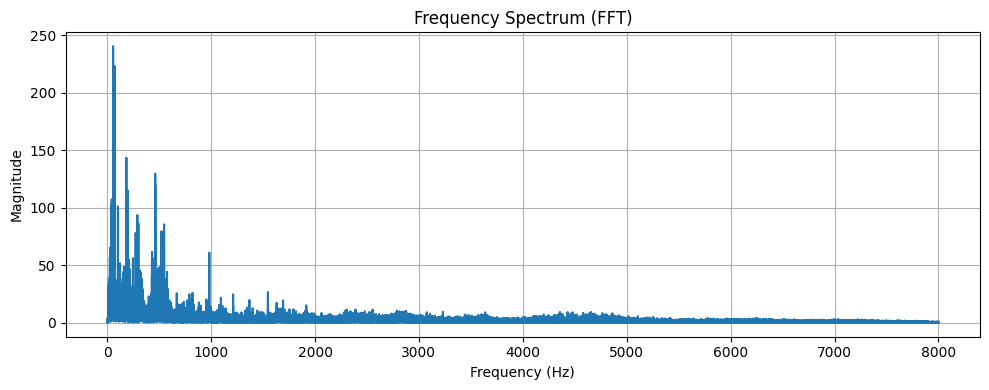

In [ ]:
fft = np.fft.fft(waveform_anomlaous)
magnitude = np.abs(fft)
freq = np.fft.fftfreq(len(magnitude), 1/sr)

# Only keep the positive frequencies
half_len = len(magnitude) // 2
magnitude = magnitude[:half_len]
freq = freq[:half_len]

# Plot
plt.figure(figsize=(10, 4))
plt.plot(freq, magnitude)
plt.title("Frequency Spectrum (FFT)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.tight_layout()
plt.show()

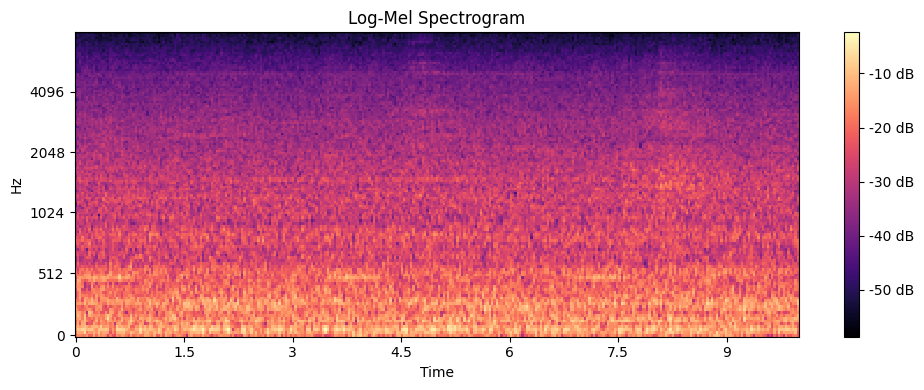

In [ ]:
import matplotlib.pyplot as plt
import librosa.display

mel_spec = librosa.feature.melspectrogram(y=waveform_standard, sr=sr, n_fft=1024, hop_length=512, n_mels=128)

log_mel_spec = librosa.power_to_db(mel_spec)
plt.figure(figsize=(10, 4))
librosa.display.specshow(log_mel_spec, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title("Log-Mel Spectrogram")
plt.tight_layout()
plt.show()


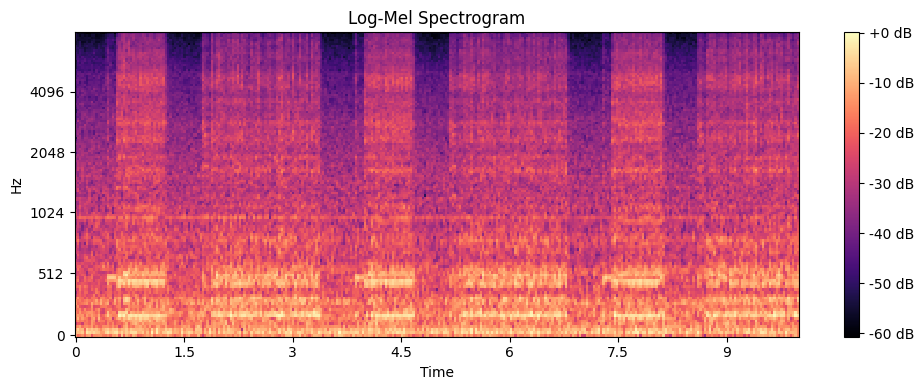

In [ ]:
import matplotlib.pyplot as plt
import librosa.display

mel_spec = librosa.feature.melspectrogram(y=waveform_anomlaous, sr=sr, n_fft=1024, hop_length=512, n_mels=128)

log_mel_spec = librosa.power_to_db(mel_spec)
plt.figure(figsize=(10, 4))
librosa.display.specshow(log_mel_spec, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title("Log-Mel Spectrogram")
plt.tight_layout()
plt.show()

In [ ]:
print(log_mel_spec.shape)

(128, 313)


In [ ]:
log_mel_spec = log_mel_spec.T  # shape: (313, 128)

def create_sequences(data, seq_len=10):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

X, y = create_sequences(log_mel_spec, seq_len=10)

NameError: name 'log_mel_spec' is not defined

In [ ]:
print(X.shape)

(303, 10, 128)


In [ ]:
print(y.shape)

(303, 128)


## PIPELINE FOR TRAINING LSTM

In [ ]:
import os
import librosa
import numpy as np

def extract_log_mel(audio_path, sr=16000, n_fft=1024, hop_length=512, n_mels=128):
    y, sr = librosa.load(audio_path, sr=sr)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    log_mel = librosa.power_to_db(mel)


    #normalization
    log_mel = np.clip(log_mel, a_min=-80, a_max=0)
    log_mel = (log_mel + 80) / 80.0  # now in [0, 1]

    return log_mel.T  # shape: (time, mel_bins)

def load_dataset_from_folder(folder_path):
    X_all = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.wav'):
            path = os.path.join(folder_path, filename)
            log_mel = extract_log_mel(path)
            X_all.append(log_mel)
    return X_all  # list of (time, freq) matrices

def create_sequences(data, seq_len=10):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

In [ ]:
def create_all_sequences(log_mel_list, seq_len=10):
    X_seq, y_seq = [], []
    for mel in log_mel_list:
        if mel.shape[0] > seq_len:
            X, y = create_sequences(mel, seq_len=seq_len)
            X_seq.append(X)
            y_seq.append(y)
    return np.concatenate(X_seq), np.concatenate(y_seq)

In [ ]:

train_folder = "/kaggle/input/dcase-aml/dev_data/dev_data/slider/train"
train_mels = load_dataset_from_folder(train_folder)

split_idx = int(len(train_mels) * 0.8)
train_mels_split = train_mels[:split_idx]
val_mels_split = train_mels[split_idx:]


X_train, y_train = create_all_sequences(train_mels_split, seq_len=10)
X_val, y_val = create_all_sequences(val_mels_split, seq_len=10)

# Convert to Pytorch and create evaluation dataset
import torch
from torch.utils.data import DataLoader, TensorDataset

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)




In [ ]:
#take a sample

from torch.utils.data import Subset
dataset_size = len(train_dataset)
subset_size = int(0.20 * dataset_size)  # 20% size

# Take first 20% indices (or random sample)
subset_indices = list(range(subset_size))

# Create subset dataset
train_subset = Subset(train_dataset, subset_indices)

# Create DataLoader on subset
train_loader_subset = DataLoader(train_subset, batch_size=32, shuffle=True)

In [ ]:
len(train_loader)

17953

In [ ]:
import torch.nn as nn

class NextFrameLSTM(nn.Module):
    def __init__(self, input_size=128, hidden_size=256, num_layers=2):
        super().__init__()
        self.lstm = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, input_size)  # Predict next mel frame

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        out, _ = self.lstm(x)  # out shape: (batch_size, seq_len, hidden_size)
        last_out = out[:, -1, :]  # Take output at last time step
        pred = self.fc(last_out)  # (batch_size, input_size)
        return pred


In [ ]:
model = NextFrameLSTM()
criterion = nn.MSELoss()  # Predicting continuous mel frames
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

### MODEL TRAINING: DO NOT RUN NEXT CELLS, already trained and saved on google drive

In [ ]:

from tqdm import tqdm

num_epochs = 10
model.train()

for epoch in range(num_epochs):
    epoch_loss = 0
    for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        optimizer.zero_grad()
        preds = model(X_batch)  # Predict next frames
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * X_batch.size(0)

    print(f"Epoch {epoch+1}, Loss: {epoch_loss / len(train_dataset):.6f}")

Epoch 1: 100%|██████████| 17953/17953 [08:49<00:00, 33.91it/s]


Epoch 1, Loss: 0.001888


Epoch 2: 100%|██████████| 17953/17953 [08:57<00:00, 33.42it/s]


Epoch 2, Loss: 0.001610


Epoch 3: 100%|██████████| 17953/17953 [08:51<00:00, 33.76it/s]


Epoch 3, Loss: 0.001567


Epoch 4: 100%|██████████| 17953/17953 [08:57<00:00, 33.40it/s]


Epoch 4, Loss: 0.001545


Epoch 5: 100%|██████████| 17953/17953 [08:56<00:00, 33.48it/s]


Epoch 5, Loss: 0.001530


Epoch 6: 100%|██████████| 17953/17953 [08:53<00:00, 33.65it/s]


Epoch 6, Loss: 0.001520


Epoch 7: 100%|██████████| 17953/17953 [08:50<00:00, 33.83it/s]


Epoch 7, Loss: 0.001512


Epoch 8: 100%|██████████| 17953/17953 [08:53<00:00, 33.66it/s]


Epoch 8, Loss: 0.001506


Epoch 9: 100%|██████████| 17953/17953 [08:50<00:00, 33.81it/s]


Epoch 9, Loss: 0.001501


Epoch 10: 100%|██████████| 17953/17953 [08:52<00:00, 33.74it/s]

Epoch 10, Loss: 0.001496


In [ ]:
torch.save(model.state_dict(), "lstm_10epochs_lr1e-3_hiddensize256_2layers_full.pth")

### EVALUATION STEP, use 20% of training data to define a threshold for classifying anomalous data


In [ ]:
def evaluate_model(model, data_loader, device="cpu"):
    model.eval()
    errors = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            preds = model(X_batch)
            batch_errors = torch.mean((preds - y_batch) ** 2, dim=1)  # (batch,)
            errors.extend(batch_errors.cpu().numpy())

    errors = np.array(errors)
    return errors

In [ ]:
device="cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
val_errors = evaluate_model(model, val_loader, device=device)
mean_error = np.mean(val_errors)
std_error = np.std(val_errors)

# Threshold: mean + k * std
threshold = mean_error

print(f"Mean val error: {mean_error:.6f}")
print(f"Std val error: {std_error:.6f}")
print(f"Anomaly threshold: {threshold:.6f}")

Mean val error: 0.001526
Std val error: 0.000381
Anomaly threshold: 0.001526


# **INFERENCE ON PRETRAINED**

*  DEFINE FUNCIONS
*  DEFINE NETWORK AGAIN
*  LOAD TEST DATA AND SET THRESHOLD FOR DETECTING ANOMALOUS   
*  LOAD PRETRAINED MODEL AND PREDICT BASED ON THRESHOLD
*  COMPUTE SCORES
*  SHOW ROC CURVE AND COMPUTE AUC




In [ ]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import librosa



In [ ]:
def extract_log_mel(audio_path, sr=16000, n_fft=1024, hop_length=512, n_mels=128):
    y, sr = librosa.load(audio_path, sr=sr)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    log_mel = librosa.power_to_db(mel)

    log_mel = np.clip(log_mel, a_min=-80, a_max=0)
    log_mel = (log_mel + 80) / 80.0  # now in [0, 1]

    return log_mel.T  # shape: (time, mel_bins)

def load_dataset_from_folder(folder_path):
    X_all = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.wav'):
            path = os.path.join(folder_path, filename)
            log_mel = extract_log_mel(path)
            X_all.append(log_mel)
    return X_all  # list of (time, freq) matrices

def create_sequences(data, seq_len=10):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

def get_label_from_filename(filename):
    if "anomaly" in filename:
        return 1  # Anomaly
    elif "normal" in filename:
        return 0  # Normal
    else:
        raise ValueError("Unknown label in filename")

def test_model(model, X_tensor, y_tensor,device):
    model.eval()
    X_tensor = X_tensor.to(device)
    y_tensor = y_tensor.to(device)
    with torch.no_grad():
        # Add batch dim: (batch_size, seq_len, input_size)
        preds = model(X_tensor)  # (num_sequences, mel_bins)
        mse_per_frame = torch.mean((preds - y_tensor) ** 2, dim=1)  # (num_sequences,)
    mean_error = mse_per_frame.mean().item()
    return mean_error, mse_per_frame.cpu().numpy()

In [ ]:
# DEFINE AGAIN THE NEWTORK
import torch.nn as nn

class NextFrameLSTM(nn.Module):
    def __init__(self, input_size=128, hidden_size=256, num_layers=2):
        super().__init__()
        self.lstm = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, input_size)  # Predict next mel frame

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        out, _ = self.lstm(x)  # out shape: (batch_size, seq_len, hidden_size)
        last_out = out[:, -1, :]  # Take output at last time step
        pred = self.fc(last_out)  # (batch_size, input_size)
        return pred

In [ ]:
#LOAD TEST DATA
test_folder = "/content/dcase-aml/dev_data/dev_data/slider/train"
test_mels = load_dataset_from_folder(test_folder)

print("test_data_loaded")

Mean_val_error=0.001526
Std_val_error=0.000381
threshold=0.001526

device="cuda" if torch.cuda.is_available() else "cpu"


test_data_loaded


In [ ]:
!pip install gdown  # if not already installed
import gdown

file_id = "1vfmljcsjSaugS68dJnPybS-v7JFGkD1c"  # Extract from your Google Drive sharing URL
output = "/content/my_pretrained_model.pth"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1vfmljcsjSaugS68dJnPybS-v7JFGkD1c
To: /content/my_pretrained_model.pth
100%|██████████| 2.90M/2.90M [00:00<00:00, 32.9MB/s]


'/content/my_pretrained_model.pth'

In [ ]:
threshold=0.001688

In [ ]:
#LOAD MODEL FROM DRIVE AND CLASSIFY TEST DATA

model = NextFrameLSTM()

model_path = '/content/my_pretrained_model.pth'
model.load_state_dict(torch.load(model_path, map_location=torch.device(device), weights_only=False))
model.to(device)
model.eval()



y_true = []
y_pred = []
anomaly_scores = []

test_folder = "/content/dcase-aml/dev_data/dev_data/slider/test"

for filename in tqdm(os.listdir(test_folder)):
    if not filename.endswith(".wav"):
        continue

    label = get_label_from_filename(filename)
    y_true.append(label)

    filepath = os.path.join(test_folder, filename)
    mel = extract_log_mel(filepath)

    if mel.shape[0] <= 10:
        continue

    X_test, y_test = create_sequences(mel, seq_len=10)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    mean_err, _ = test_model(model, X_test_tensor, y_test_tensor, device=device)
    anomaly_scores.append(mean_err)

    prediction = 1 if mean_err > threshold else 0
    y_pred.append(prediction)

    #print(f"{filename}: error = {mean_err:.6f}, predicted = {'anomaly' if prediction else 'normal'}")


100%|██████████| 1101/1101 [00:19<00:00, 56.45it/s]


In [ ]:
#COMPUTE METRICS
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("✅ Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Normal", "Anomaly"]))

print("📊 Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print(f"🎯 Accuracy: {accuracy_score(y_true, y_pred):.4f}")

✅ Classification Report:
              precision    recall  f1-score   support

      Normal       0.76      0.90      0.82       300
     Anomaly       0.96      0.89      0.92       801

    accuracy                           0.89      1101
   macro avg       0.86      0.89      0.87      1101
weighted avg       0.90      0.89      0.90      1101

📊 Confusion Matrix:
[[269  31]
 [ 87 714]]
🎯 Accuracy: 0.8928


In [ ]:
#COMPUTE METRICS
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("✅ Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Normal", "Anomaly"]))

print("📊 Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print(f"🎯 Accuracy: {accuracy_score(y_true, y_pred):.4f}")

✅ Classification Report:
              precision    recall  f1-score   support

      Normal       0.84      0.61      0.70       300
     Anomaly       0.87      0.96      0.91       801

    accuracy                           0.86      1101
   macro avg       0.85      0.78      0.81      1101
weighted avg       0.86      0.86      0.85      1101

📊 Confusion Matrix:
[[182 118]
 [ 35 766]]
🎯 Accuracy: 0.8610


ROC AUC: 0.9406


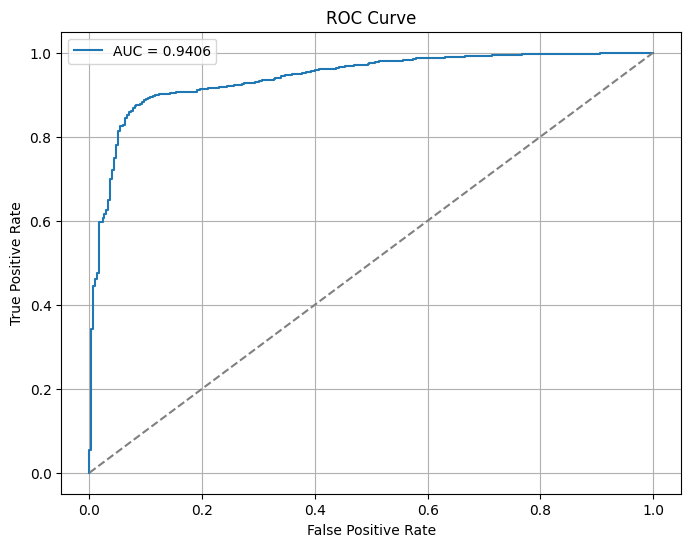

In [ ]:
#COMPUTE AUC AND PLOT ROC CURVE

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Compute ROC AUC
auc_score = roc_auc_score(y_true, anomaly_scores)
print(f"ROC AUC: {auc_score:.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_true, anomaly_scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#find best threshold
distances = np.sqrt((fpr - 0)**2 + (tpr - 1)**2)
best_idx = np.argmin(distances)
best_threshold = thresholds[best_idx]

print(f"Best threshold (top-left method): {best_threshold:.6f}")

Best threshold (top-left method): 0.001688
